In [69]:
using Revise
using DynamicsAndControl
using StaticArrays
using Rotations
using OrdinaryDiffEq
using LinearAlgebra
using Plots
gr()

Plots.GRBackend()

In [19]:
@dynamics PlanarRocketLanding{T} begin
    @integrable begin
        r::SVector{2, T} 
        v::SVector{2, T}
        θ::T
        ω::T
        m::T
    end

    @direct begin
        landed::Bool
    end
end

PlanarRocketLanding

In [20]:
@controller RocketLandingController{T} begin
    @outputs begin
        δ_gim::T
        T_thrust::T
    end
end

RocketLandingController

In [22]:
function DynamicsAndControl.initialize(::Type{PlanarRocketLanding}, config)
    x0 = config.x0

    return (x0.r, x0.v, x0.θ, x0.ω, x0.m), (false,), config.params
end

In [70]:
function DynamicsAndControl.dynamics!(this::PlanarRocketLanding, ẋ, x, u, t)
    @unpack Isp, J, t_hat_body, g0 = static(this)
    @unpack r, v, θ, ω, m, landed = x
    @unpack δ_gim, T_thrust = u

    f_thrust = T_thrust*RotMatrix(θ)*t_hat_body
    f_grav = @SVector([0.0, -m*g0])
    f_total = f_thrust + f_grav
    
    K_e = 1/2*m*norm(v)^2

    if !landed
        ẋ.r = v
        ẋ.v = f_total/m
        ẋ.θ = ω
        ẋ.ω = T_thrust*sin(δ_gim)/J
        ẋ.m = -T_thrust/(Isp*g0)
    else
        ẋ.r = ẋ.v = @SVector zeros(2)
        ẋ.θ = ẋ.ω = 0.0
    end

    log!(this, :state, t, (a=ẋ.v, ω̇=ẋ.ω, ṁ=ẋ.m, r, v, θ, ω, m))
    log!(this, :forces, t, (;f_thrust, f_grav, f_total, K_e))
end

function DynamicsAndControl.update!(this::PlanarRocketLanding, ẋ, x, u, t)
    if(x.r[2] <= 0.0)
        x.landed = true
    end
    
    return false
end

In [71]:
DynamicsAndControl.initialize(::Type{RocketLandingController}, config) = (), (0.0, 0.0), config

In [72]:
function DynamicsAndControl.update!(this::RocketLandingController, u, _, x, t)
    @unpack m = x
    @unpack T_W, g0 = static(this)

    T_thrust = m*g0*T_W
    δ_gim = 0.0

    @pack! u = T_thrust, δ_gim

    log!(this, :outputs, t, (;T_thrust, δ_gim))
end

In [73]:
dynamics_conf = ( 
                  x0 = (
                         r = @SVector([.5e3, 2e3]), 
                         v = @SVector([-50.0, -250.0]),
                         θ = -20*π/180,
                         ω = .3*π/180,
                         m = 1e5,
                    ),
                  params = (
                        Isp = 300,
                        g0 = 9.81,
                        J = 1e6,
                        t_hat_body = @SVector [-1.0, 0.0]
                    )
)

(x0 = (r = [500.0, 2000.0], v = [-50.0, -250.0], θ = -0.3490658503988659, ω = 0.005235987755982988, m = 100000.0), params = (Isp = 300, g0 = 9.81, J = 1.0e6, t_hat_body = [-1.0, 0.0]))

In [74]:
control_conf = ( T_W = 1.1, g0 = 9.81)

(T_W = 1.1, g0 = 9.81)

In [75]:
sim = Simulation(
                    ( :truth, PlanarRocketLanding, dynamics_conf ),
                    ( :controller, RocketLandingController, control_conf ),
                    10.0, RK4(), dt=0.02
)

Simulation with dt=0.02, tspan=(0.0, 10.0), solver=RK4, components=
	dynamics: PlanarRocketLanding
	sensor: DynamicsAndControl.FullStateSensor
	controller: RocketLandingController
	actuator: DynamicsAndControl.PassthroughActuator


In [76]:
data = simulate(sim)

Simulation data set with immediate namespaces:
	[:truth, :controller]


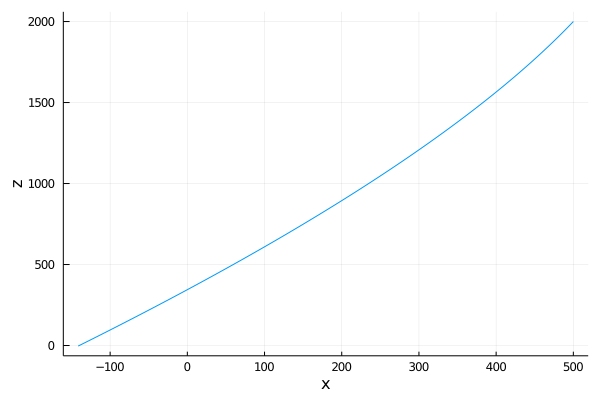

In [77]:
let p = data.truth.state
    plot(p.r[1], p.r[2], xlabel="x", ylabel="z", label=false)
end

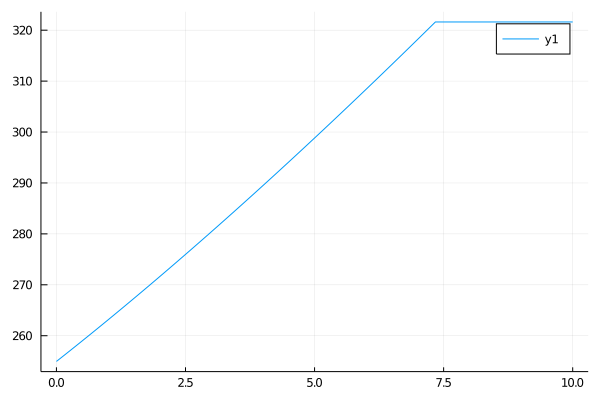

In [78]:
let p = data.truth.state
    #plot(p.time, p.v, label=["vx" "vz"])
    plot(p.time, norm.(p.v))
end

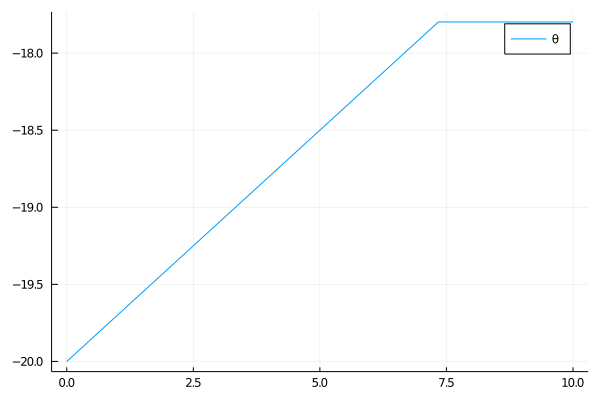

In [79]:
let p = data.truth.state
    plot(p.time, p.θ.*180/π, label="θ")
end

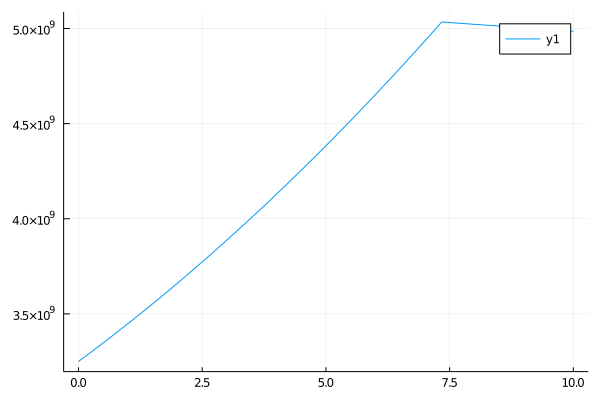

In [80]:
let p = data.truth.forces
    #plot(p.time, p.f_thrust, label=["fx" "fz"])
    plot(p.time, p.K_e)
end